In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [109]:
import sys
sys.path.append("../")
from audio import *
import random
from fastai.callbacks import *
from IPython.core.debugger import set_trace
np.random.seed(2)
p = Config.data_path()/'freesound-audio-tagging-2019';
print(p)

/home/h/.fastai/data/freesound-audio-tagging-2019


In [3]:
!kaggle competitions download -c freesound-audio-tagging-2019 -p {p}

train_noisy.zip: Skipping, found more recently modified local copy (use --force to force download)
train_noisy.csv: Skipping, found more recently modified local copy (use --force to force download)
train_curated.zip: Skipping, found more recently modified local copy (use --force to force download)
train_curated.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [110]:
train_path = p/'train_noisy'
valid_path = p/'train_curated'

213
Tap;Clapping
AudioItem 0.5 seconds (22050 samples @ 44100hz)


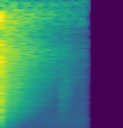

In [269]:
config = AudioTransformConfig()
config.force_cache = True
# config.remove_silence = True
config.silence_threshold = 3
config.silence_padding = 250
config.sg_cfg.f_max = 44100
config.segment_size = 500
config.window_size = 400
config.sg_cfg.n_mels = 128
config.sg_cfg.n_fft = 128*20
config.sg_cfg.hop = 180
config.to_db_scale = True
config.top_db = 120
config.max_to_pad = 500
items = ItemList.from_csv(valid_path, '../train_curated.csv').split_none().label_from_df(cols='labels', label_delim=',')
carr = []
arr = []

# Get one from each class
for i in range(len(items.x)):
    if not str(items.y[i]) in carr:
        carr.append(str(items.y[i]))
        arr.append(items.x[i])

        
print(len(arr))
# DODGY: TAP (21) Church Bell(37)  Clapping (88)
i = 104
for i, e in enumerate(arr):
    print(carr[i])
    prevs = preview_transforms(arr[i], valid_path, config)
    for i,y in prevs: i.show()

In [126]:
valid = AudioList.from_csv(valid_path, '../train_curated.csv', config=config).split_by_rand_pct(.2, seed=2).label_from_df(cols='labels', label_delim=',')
tfms = get_spectro_transforms(roll=False, num_rows=10, num_cols=10)
db = valid.transform(tfms).databunch(bs=80)
db

AudioDataBunch;

Train: AudioLabelList (13343 items)
x: AudioList
AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz)
Path: /home/h/.fastai/data/freesound-audio-tagging-2019/train_curated;

Valid: AudioLabelList (3306 items)
x: AudioList
AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz),AudioItem 2.0 seconds (88200 samples @ 44100hz)
Path: /home/h/.fastai/data/freesound-audio-tagging-2019/train_curated;

Test: None

AudioItem 2.0 seconds (88200 samples @ 44100hz)


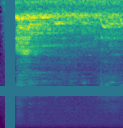

In [100]:
db.train_ds[0][0].show()

In [101]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class


# Wrapper for fast.ai library
def lwlrap(scores, truth, **kwargs):
    score, weight = calculate_per_class_lwlrap(to_np(truth), to_np(scores))
    return torch.Tensor([(score * weight).sum()])

In [102]:
learn = audio_learner(db, metrics=[lwlrap], pretrained=False, callback_fns=[CSVLogger, ShowGraph])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


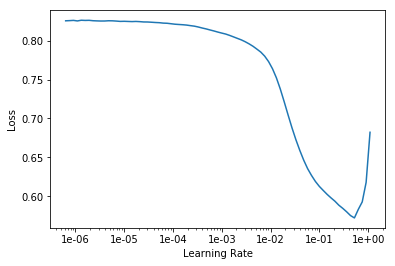

In [103]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,lwlrap,time
0,0.342166,0.175016,0.136682,00:18
1,0.120755,0.067024,0.289450,00:17
2,0.075679,0.061825,0.350361,00:17
3,0.061015,0.060607,0.447421,00:17
4,0.054221,0.054840,0.472042,00:17


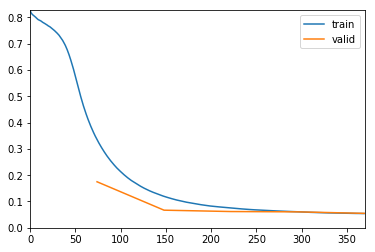

In [104]:
learn.fit_one_cycle(5, 1e-2)
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


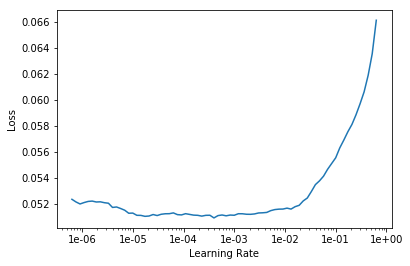

In [105]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,lwlrap,time
0,0.050320,0.054978,0.485262,00:18
1,0.049814,0.054801,0.479575,00:17
2,0.049699,0.067715,0.466872,00:17
3,0.048604,0.055047,0.456200,00:17
4,0.045609,0.053291,0.496219,00:18
5,0.042155,0.048926,0.537966,00:17
6,0.038609,0.051547,0.524595,00:17
7,0.034972,0.049593,0.570237,00:17
8,0.031726,0.047535,0.577741,00:17
9,0.028290,0.049844,0.574852,00:17


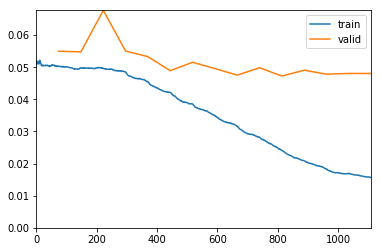

In [106]:
learn.load('stage-1')
learn.fit_one_cycle(15, slice(1e-3, 1e-2))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


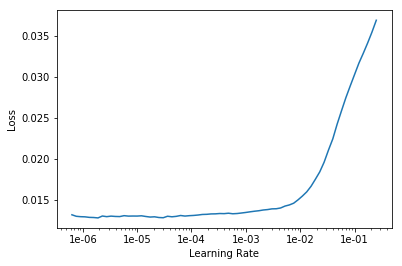

In [96]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,lwlrap,time
0,0.013991,0.049935,0.613711,00:18
1,0.015189,0.053337,0.596014,00:17
2,0.017766,0.057405,0.571968,00:17
3,0.017947,0.053034,0.592786,00:17
4,0.016016,0.054590,0.600180,00:17


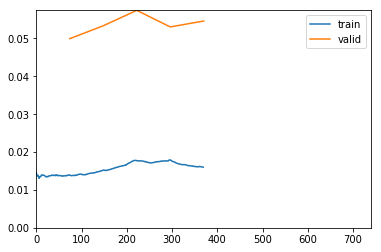

In [ ]:
learn.fit_one_cycle(10, slice(1e-3, 3e-3))